## Import Packages

In [1]:
import numpy as np
import pandas as pd
from pytrends.request import TrendReq
from scipy import signal
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Extract confirmed case numbers for target countries

In [2]:
def extract_target_country_case(filename, country_list):
    covid_all = pd.read_csv(filename)
    covid_target = covid_all[covid_all['Country/Region'].isin(country_list)]
    covid_target = covid_target.drop(columns=['Province/State','Lat','Long'])
    # adding up the confirmed case numbers for countires with multiple rows
    for country in country_list:
        covid_multiple_rows = covid_target[covid_target['Country/Region']==country]
        if covid_multiple_rows.shape[0] > 1:
            covid_target = covid_target.drop(covid_multiple_rows.index)
            covid_single_row = covid_multiple_rows.groupby('Country/Region').sum().reset_index()
            covid_target = covid_target.append(covid_single_row).reset_index(drop=True)
        else:
            continue
    return(covid_target)

In [3]:
filename = "data/time_series_covid19_confirmed_global.csv"
country_code_dict = {'Taiwan*':'TW', 'Korea, South':'KR', 'Italy':'IT', 'Spain':'ES', 'Czechia':'CZ', 
                     'US':'US', 'Peru':'PE', 'Iran':'IR', 'Australia':'AU', 'South Africa':'ZA'}
country_list = list(country_code_dict.keys())
confirmed_case_target = extract_target_country_case(filename, country_list)

In [4]:
confirmed_case_target

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20
0,Czechia,0,0,0,0,0,0,0,0,0,...,6216,6433,6549,6606,6746,6900,7033,7132,7187,7273
1,Iran,0,0,0,0,0,0,0,0,0,...,76389,77995,79494,80868,82211,83505,84802,85996,87026,88194
2,Italy,0,0,0,0,0,0,0,0,0,...,165155,168941,172434,175925,178972,181228,183957,187327,189973,192994
3,"Korea, South",1,1,2,2,3,4,4,4,4,...,10591,10613,10635,10653,10661,10674,10683,10694,10708,10718
4,Peru,0,0,0,0,0,0,0,0,0,...,11475,12491,13489,14420,15628,16325,17837,19250,20914,21648
5,South Africa,0,0,0,0,0,0,0,0,0,...,2506,2605,2783,3034,3158,3300,3465,3635,3953,4220
6,Spain,0,0,0,0,0,0,0,0,0,...,177644,184948,190839,191726,198674,200210,204178,208389,213024,219764
7,Taiwan*,1,1,3,3,4,5,8,8,9,...,395,395,395,398,420,422,425,426,427,428
8,US,1,1,2,2,5,5,5,5,5,...,636350,667592,699706,732197,758809,784326,811865,840351,869170,905358
9,Australia,0,0,0,0,4,5,5,6,9,...,6440,6462,6522,6568,6610,6623,6645,6652,6662,6677


### Transpose confirmed_case_target dataframe

In [5]:
df_country = pd.DataFrame(country_code_dict.items(), columns=['Name','Code'])
confirmed_case_target = pd.merge(confirmed_case_target, df_country, how='left', left_on='Country/Region', right_on='Name')
confirmed_case_tr = confirmed_case_target.transpose()

# set country code as the column names of the transposed dataframe
confirmed_case_tr.columns = confirmed_case_tr.loc['Code']
confirmed_case_tr = confirmed_case_tr.drop(['Country/Region','Name','Code'])

# set date as the index of the transposed dataframe
confirmed_case_tr.index = pd.to_datetime(confirmed_case_tr.index)

In [6]:
confirmed_case_tr.tail()

Code,CZ,IR,IT,KR,PE,ZA,ES,TW,US,AU
2020-04-20,6900,83505,181228,10674,16325,3300,200210,422,784326,6623
2020-04-21,7033,84802,183957,10683,17837,3465,204178,425,811865,6645
2020-04-22,7132,85996,187327,10694,19250,3635,208389,426,840351,6652
2020-04-23,7187,87026,189973,10708,20914,3953,213024,427,869170,6662
2020-04-24,7273,88194,192994,10718,21648,4220,219764,428,905358,6677


### Extract search trend of keywords from Google Trends for each target country

In [7]:
def extract_google_trends(timeframe, keywords_dict):
    pytrend = TrendReq(hl='en-US', tz=360)
    search_trend_dict = {}
    for key in list(keywords_dict.keys()):
        pytrend.build_payload(kw_list=keywords_dict[key], cat=0, timeframe=timeframe, geo=key)
        df_search_trend = pytrend.interest_over_time().drop(columns=['isPartial'])
        # rename the columns of df_search_trend to English keywords
        df_search_trend.columns = keywords_dict['US']
        search_trend_dict[key] = df_search_trend
    return(search_trend_dict)

In [8]:
timeframe = '2020-01-01 ' + confirmed_case_tr.index[-1].strftime('%Y-%m-%d')
keywords_dict = {'TW':['武漢', '冠狀病毒', '武漢肺炎', '肺炎', '新冠肺炎'],
                 'KR':['우한', '코로나바이러스', '우한 폐렴', '폐렴', '신종 코로나바이러스'],
                 'IT': ['Wuhan', 'coronavirus', 'Polmonite di Wuhan', 'Polmonite', 'covid'],
                 'ES': ['Wuhan', 'coronavirus', 'neumonía de Wuhan', 'neumonía', 'covid'],
                 'US':['Wuhan', 'coronavirus', 'Wuhan coronavirus', 'pneumonia', 'covid'],
                 'IR':['ووهان','کروناویروس','ووهان کروناویروس','سینه‌پهلو','کووید'],
                 'PE':['Wuhan', 'coronavirus', 'neumonía de Wuhan', 'neumonía', 'covid'],
                 'AU':['Wuhan', 'coronavirus', 'Wuhan coronavirus', 'pneumonia','covid'],
                 'CZ': ['Wu-chan', 'koronavirus', 'wuchanský koronavirus', 'zápal plic', 'covid'],
                 'ZA':['Wuhan', 'coronavirus', 'Wuhan Koronavirus', 'Longontsteking','covid']}

search_trend_dict = extract_google_trends(timeframe, keywords_dict)

In [9]:
search_trend_dict['TW'].tail()

,Wuhan,coronavirus,Wuhan coronavirus,pneumonia,covid
date,,,,,
2020-04-20,17,1,0,28,0
2020-04-21,17,1,0,25,0
2020-04-22,14,1,0,20,0
2020-04-23,12,1,0,17,0
2020-04-24,12,1,0,16,0


### Merge confirmed case dataframe to Google Trends query results
* Reference:
https://thispointer.com/pandas-how-to-merge-dataframes-by-index-using-dataframe-merge-part-3/

In [10]:
for key in search_trend_dict:
    df_merged = pd.merge(search_trend_dict[key], confirmed_case_tr[key], how='left', left_index=True, right_index=True)
    df_merged[key] = df_merged[key].fillna(0)
    search_trend_dict[key] = df_merged.rename(columns={key:"Confirmed Case"})

In [11]:
search_trend_dict['TW'].tail()

,Wuhan,coronavirus,Wuhan coronavirus,pneumonia,covid,Confirmed Case
date,,,,,,
2020-04-20,17,1,0,28,0,422
2020-04-21,17,1,0,25,0,425
2020-04-22,14,1,0,20,0,426
2020-04-23,12,1,0,17,0,427
2020-04-24,12,1,0,16,0,428


### Find the date on which the pandemic becomes notable in each country
* Reference:
#### (1) https://plotly.com/python/smoothing/
#### (2) https://pypi.org/project/kneed/#input-data

In [12]:
def find_notable_date(confirmed_case):
    # smooth the confirmed case curve
    confirmed_case_smooth = pd.Series(signal.savgol_filter(confirmed_case, 15, 3), index=confirmed_case.index)
    
    # find the notable date with the maximum change in daily increased case
    daily_case_change_smooth = confirmed_case_smooth-2*confirmed_case_smooth.shift(1)+confirmed_case_smooth.shift(2)
    notable_date = daily_case_change_smooth.idxmax().strftime("%Y-%m-%d")
    return(notable_date)

In [13]:
for key in search_trend_dict:
    confirmed_case = search_trend_dict[key]['Confirmed Case']
    notable_date = find_notable_date(confirmed_case)
    index = datetime.strptime(notable_date,'%Y-%m-%d')
    print("Notable date of", key, ": ", notable_date)
    print(confirmed_case[index-timedelta(5):index],"\n")

Notable date of TW :  2020-03-18
date
2020-03-13     50
2020-03-14     53
2020-03-15     59
2020-03-16     67
2020-03-17     77
2020-03-18    100
Name: Confirmed Case, dtype: int64 

Notable date of KR :  2020-02-26
date
2020-02-21     204
2020-02-22     433
2020-02-23     602
2020-02-24     833
2020-02-25     977
2020-02-26    1261
Name: Confirmed Case, dtype: int64 

Notable date of IT :  2020-03-16
date
2020-03-11    12462
2020-03-12    12462
2020-03-13    17660
2020-03-14    21157
2020-03-15    24747
2020-03-16    27980
Name: Confirmed Case, dtype: int64 

Notable date of ES :  2020-03-21
date
2020-03-16     9942
2020-03-17    11748
2020-03-18    13910
2020-03-19    17963
2020-03-20    20410
2020-03-21    25374
Name: Confirmed Case, dtype: int64 

Notable date of US :  2020-03-29
date
2020-03-24     53736
2020-03-25     65778
2020-03-26     83836
2020-03-27    101657
2020-03-28    121465
2020-03-29    140909
Name: Confirmed Case, dtype: int64 

Notable date of IR :  2020-03-26
date

### Plot keyword search trends vs. confirmed cases number over time for each country
* Reference:
#### (1) https://seaborn.pydata.org/tutorial/color_palettes.html
#### (2) https://matplotlib.org/3.2.1/gallery/shapes_and_collections/fancybox_demo.html
#### (3) https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

In [14]:
def plot_KWsearch_case_trends(trend, country_code):
    t = trend.index.values
    confirmed_case = trend['Confirmed Case']
    notable_date = find_notable_date(confirmed_case)
    confirmed_case_smooth = pd.Series(signal.savgol_filter(confirmed_case, 15, 3), index=confirmed_case.index)

    title = "Keyword Search Trends & Number of Confirmed Cases Over Time_"+country_code
    label = list(trend.columns)[:-1]
    color = sns.color_palette("husl", len(label))  
    
    # plot the search trend of each keyword
    pd.plotting.register_matplotlib_converters()
    fig, ax1 = plt.subplots(figsize=(25, 10))
    for i in range(len(label)):    
        ax1.plot(t, trend.iloc[:,i], color=color[i], label=label[i], linewidth=3)
        
    # plot the number of confirmed cases & the notable date
    ax2 = ax1.twinx()
    ax2.plot(t, confirmed_case, color='red', label='# of Confirmed Cases', linewidth=5)
    #ax2.plot(t, confirmed_case_smooth, color='green', linewidth=5)
    ax2.axvline(notable_date, color='blue', ls='--', lw=3)
    bbox = dict(fc='white',ec='blue',alpha=0.6)
    ax2.text(notable_date, confirmed_case[-1]*0.97, notable_date, color='blue', fontsize=20, bbox=bbox, ha='center')

    date_form = mdates.DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.set_ylabel('Popularity of Keyword Search', fontsize=20)
    ax2.set_ylabel('Number of Confirmed Cases', fontsize=20, color='red')
    ax1.tick_params(axis='x', labelsize=15, labelrotation=45)
    ax1.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=15)
    ax1.grid(linewidth=0.5, color='gray')
    fig.legend(fontsize=15, loc=(0.07,0.7))
    plt.title(title, fontsize=25)
    plt.show()

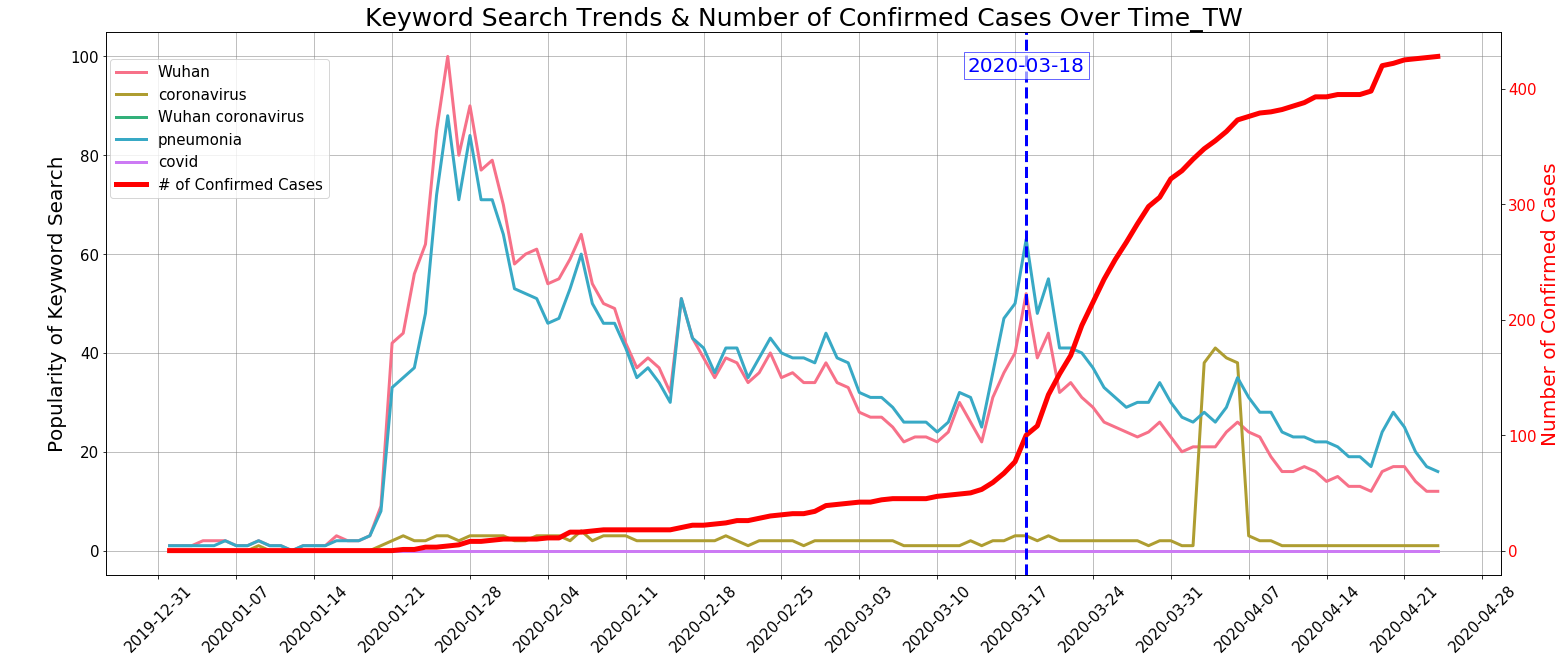

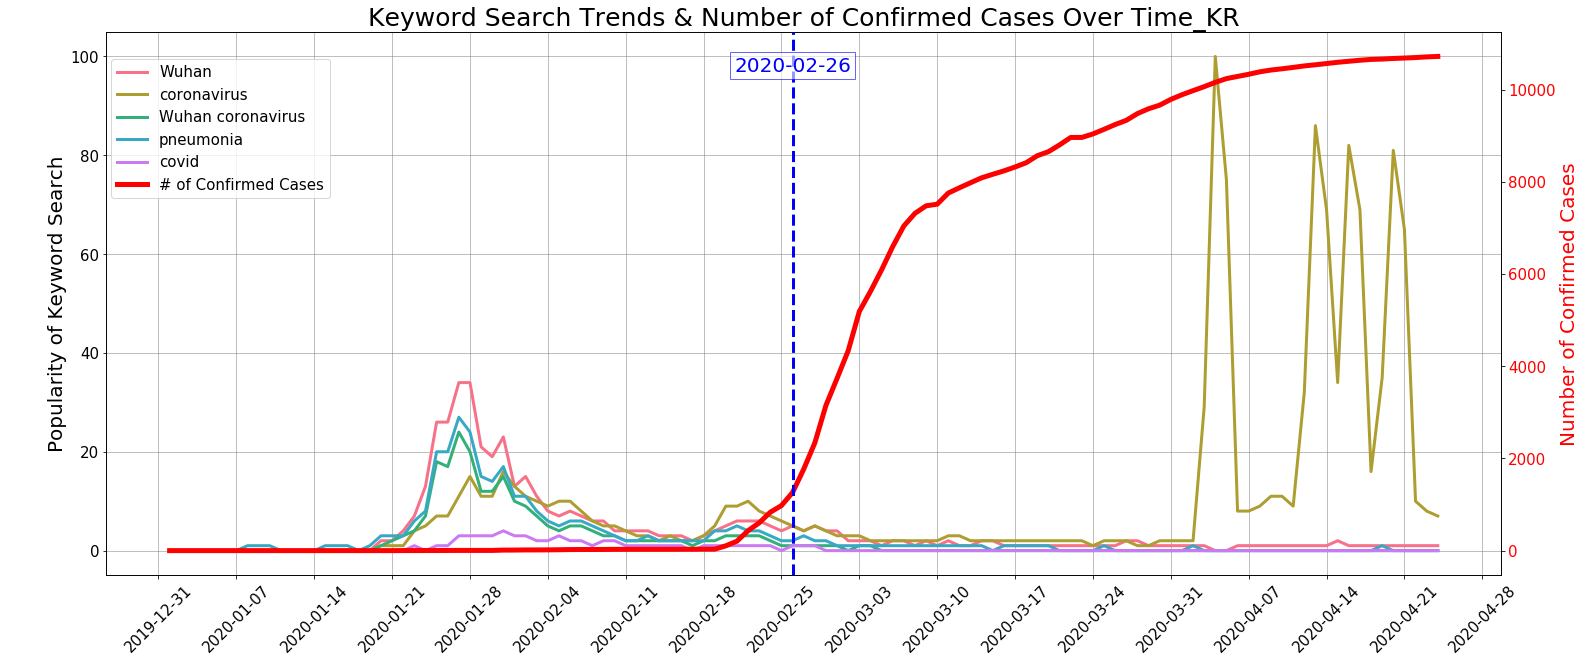

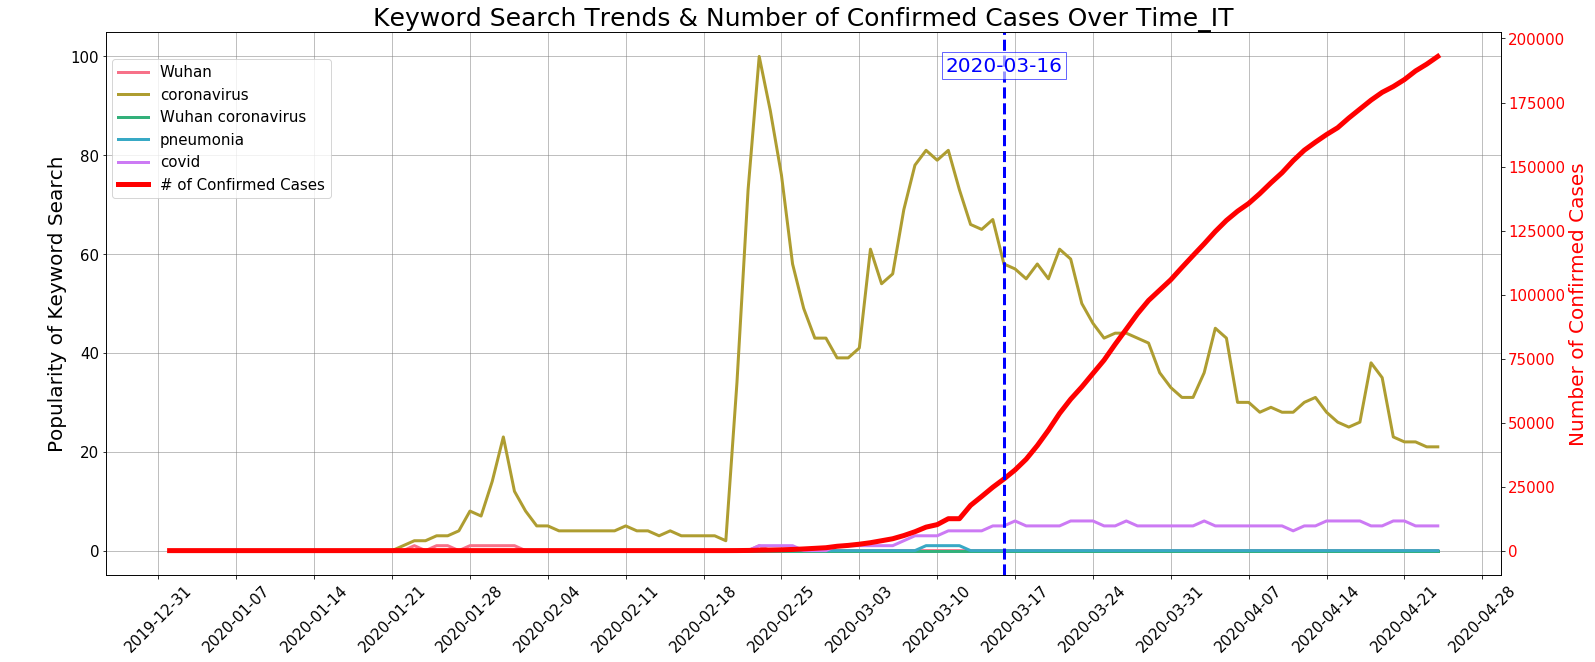

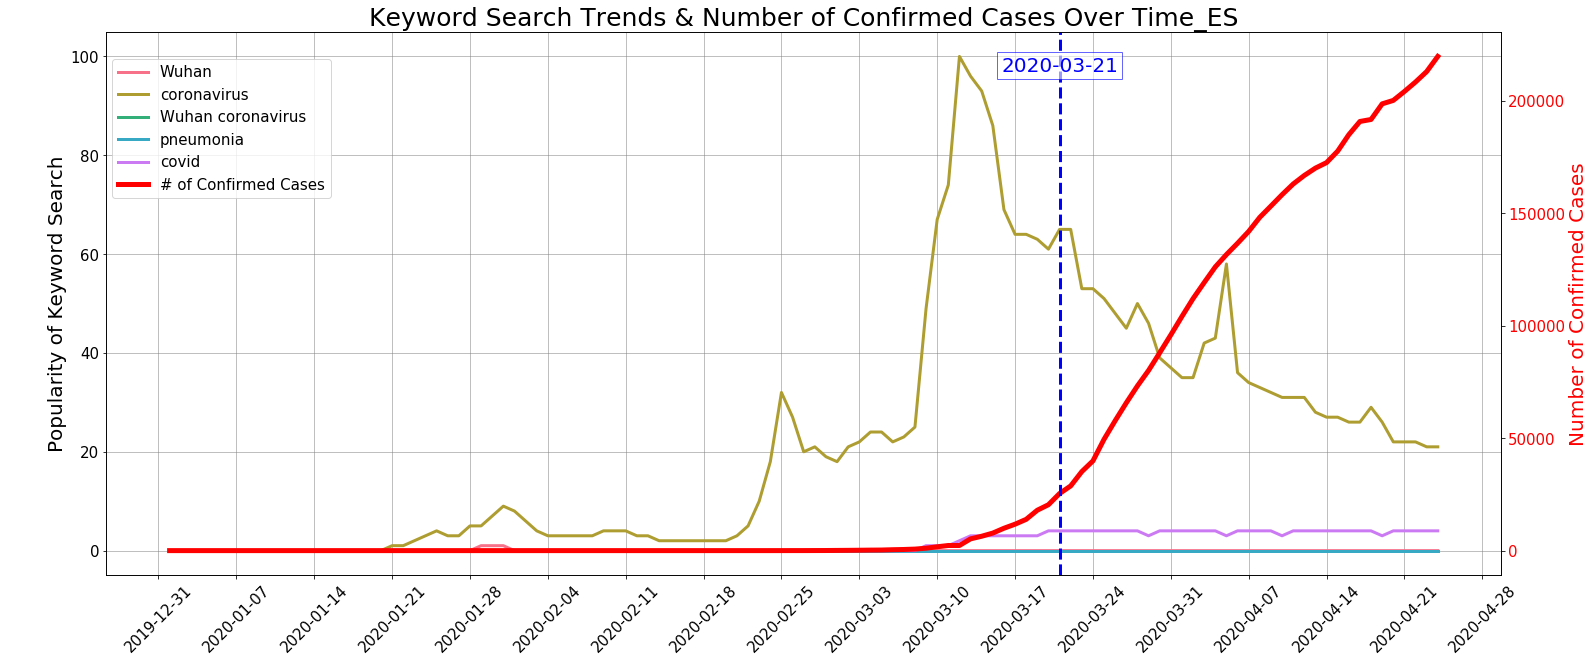

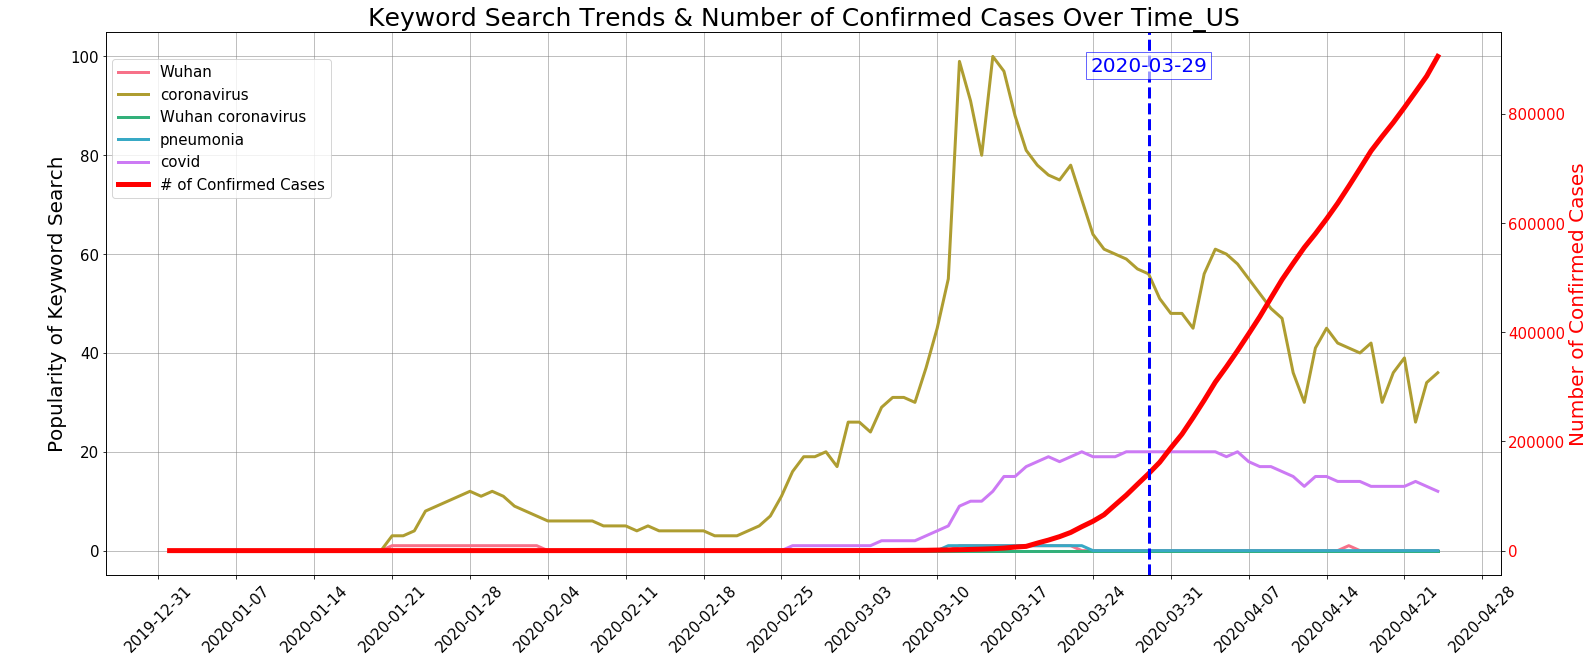

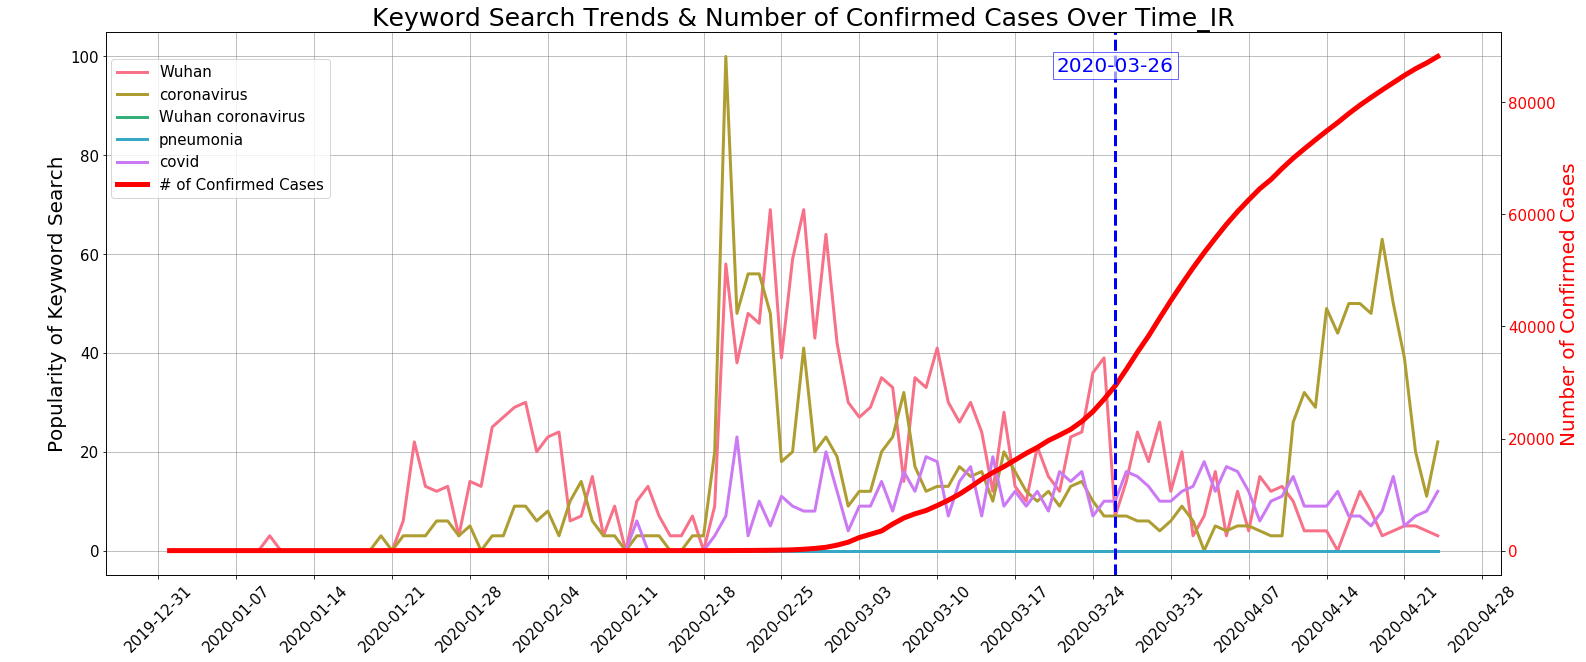

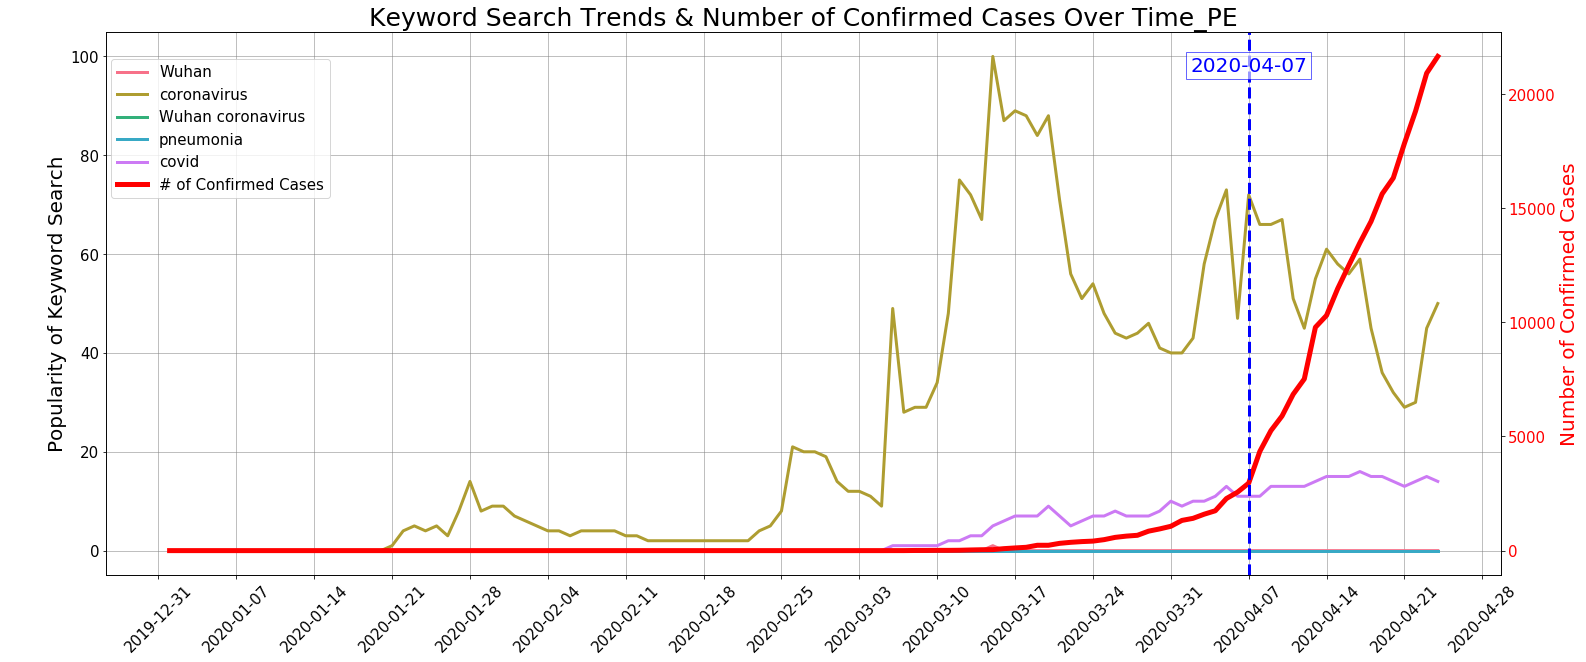

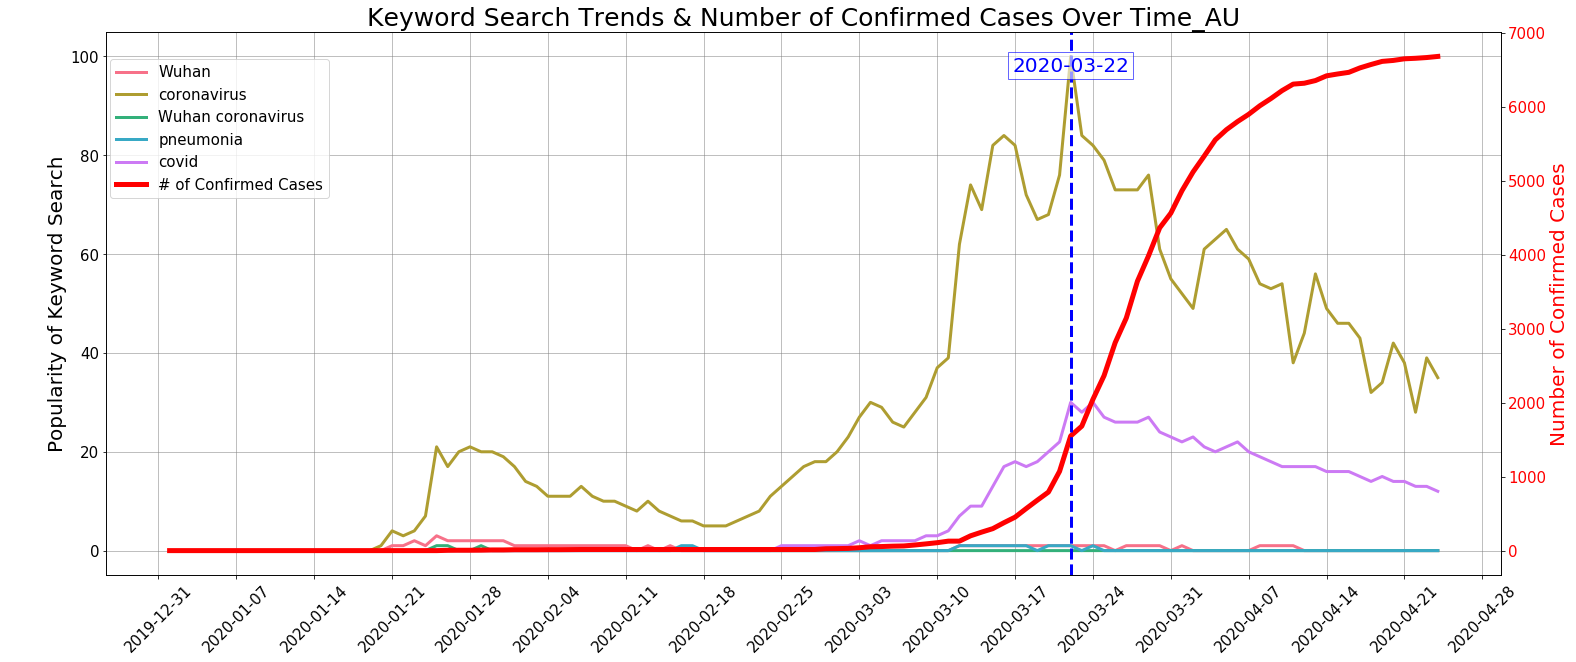

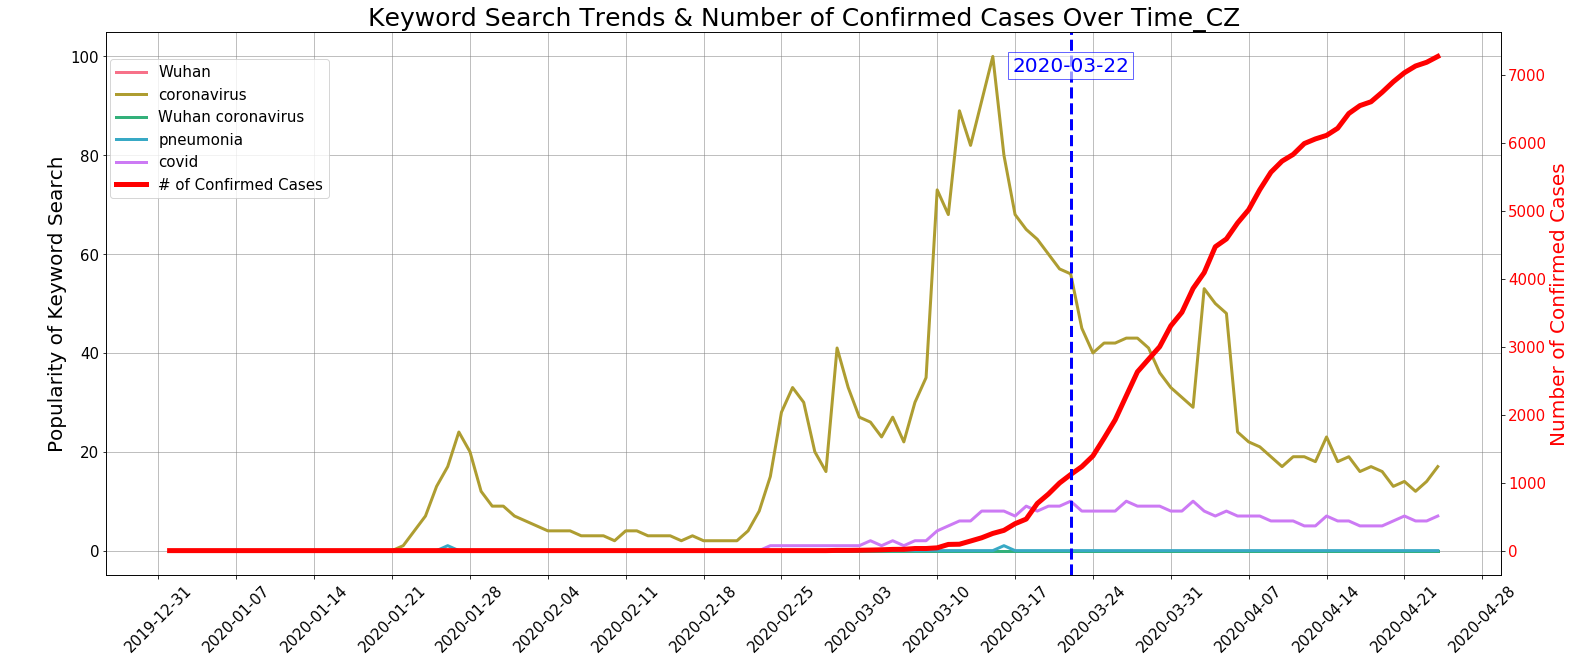

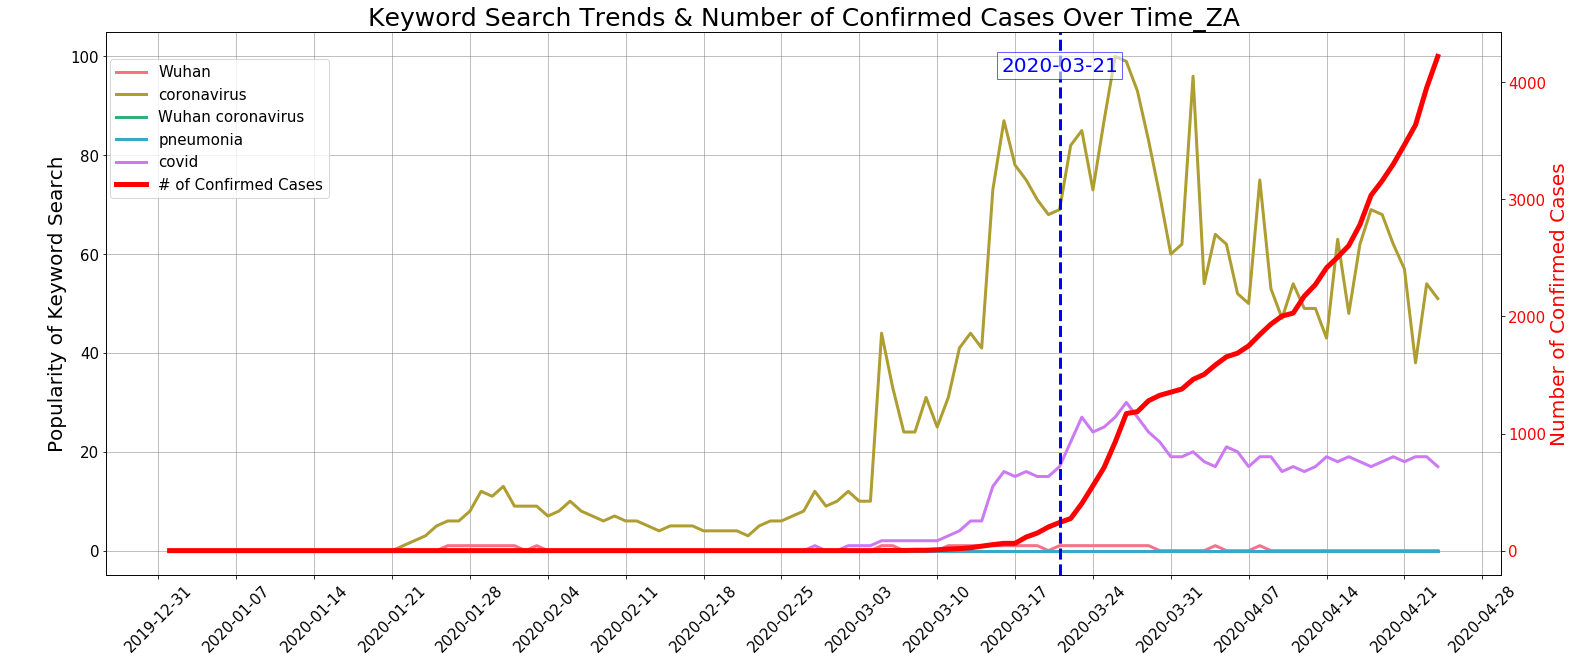

In [15]:
for key in search_trend_dict:
    trend = search_trend_dict[key]
    plot_KWsearch_case_trends(trend, key)

### Problem: 台灣的'武漢肺炎'、'新冠肺炎' & 捷克的'武漢肺炎'因搜尋資料不足皆為0

<img src="GT_Results/TW_Wuhan coronavirus(local).png">

<img src="GT_Results/TW_covid(local).png">

<img src="GT_Results/CZ_Wuhan coronavirus(local).png">

### 3. Keywords search results may exist some incorrect data

<img src="GT_Results/TW_Wuhan.png">

<img src="GT_Results/TW_Wuhan coronavirus.png">

<img src="GT_Results/IT_Wuhan coronavirus(local).png">

<img src="GT_Results/CZ_pneumonia(local).png">

### To find the search peak date for evaluating Awareness Degree of each country

In [16]:
def find_search_peak_date(search_trend_dict, most_popular_keywords_dict):
    search_peak_dict = {}
    for key in search_trend_dict:
        search_peak_dict[key] = search_trend_dict[key][most_popular_keywords_dict[key]].idxmax()
    return(search_peak_dict)

In [17]:
most_popular_keywords_dict = {'TW': 'Wuhan',
                              'KR': 'Wuhan',
                              'IT': 'coronavirus',
                              'ES': 'coronavirus',
                              'CZ': 'coronavirus',
                              'US': 'coronavirus',
                              'PE': 'coronavirus',
                              'IR': 'coronavirus',
                              'AU': 'coronavirus',
                              'ZA': 'coronavirus'}

search_peak_dict = find_search_peak_date(search_trend_dict, most_popular_keywords_dict)

In [18]:
notable_date_dict = {}
for key in search_trend_dict:
    confirmed_case = search_trend_dict[key]['Confirmed Case']
    notable_date = find_notable_date(confirmed_case)
    notable_date_dict[key] = datetime.strptime(notable_date,'%Y-%m-%d')

In [19]:
aware_period_in_days = {}
for key in search_trend_dict:
    aware_days = datetime.date(notable_date_dict[key]) - datetime.date(search_peak_dict[key])
    aware_period_in_days[key] = aware_days.days

### Severity Degree-- measured in "Confirmed Cases per Million People"

In [20]:
def popul_density_target_country(filename, country_list_popul, country_dict_popul):
    popul_density = pd.read_csv(filename)
    popul_target = popul_density[popul_density['Country (or dependency)'].isin(country_dict_popul.values())]
    popul_target = popul_target[['Country (or dependency)', 'Density (P/Km?)', 'Population (2020)']]
    return popul_target

In [21]:
filename = 'data/Countries in the world by population (2020).csv'

country_dict_popul = {'Taiwan*':'Taiwan', 'Korea, South':'South Korea', 'Italy':'Italy', 'Spain':'Spain', 'Czechia':'Czech Republic (Czechia)',
                     'US':'United States', 'Peru':'Peru', 'Iran':'Iran', 'Australia':'Australia', 'South Africa':'South Africa'}
country_list_popul = list(country_dict_popul.values())
popul_density_target = popul_density_target_country(filename, country_dict_popul, country_dict_popul)

In [22]:
popul_density_target.insert(0, "Country/Region",
                            ["US", "Iran", "Italy", "South Africa", "Korea, South", 
                             "Spain", "Peru", "Australia", "Taiwan*", "Czechia"])
popul_density_with_c = popul_density_target.merge(confirmed_case_target, left_on = "Country/Region", right_on = "Country/Region")
pandemic_severity = popul_density_with_c['4/24/20'] / popul_density_with_c['Population (2020)'].div(1000000)
popul_density_with_c.insert(4, "Severity", round(pandemic_severity, 2))

* Reference of adding Column with Dictionary values: 
#### https://cmdlinetips.com/2018/01/how-to-add-a-new-column-to-using-a-dictionary-in-pandas-data-frame/

In [23]:
popul_density_with_c.insert(4, "Country Code", popul_density_with_c["Country/Region"].map(country_code_dict))
popul_density_with_c

,Country/Region,Country (or dependency),Density (P/Km?),Population (2020),Country Code,Severity,1/22/20,1/23/20,1/24/20,1/25/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,Name,Code
0,US,United States,36,331002651,US,2735.20,1,1,2,2,...,699706,732197,758809,784326,811865,840351,869170,905358,US,US
1,Iran,Iran,52,83992949,IR,1050.02,0,0,0,0,...,79494,80868,82211,83505,84802,85996,87026,88194,Iran,IR
2,Italy,Italy,206,60461826,IT,3192.00,0,0,0,0,...,172434,175925,178972,181228,183957,187327,189973,192994,Italy,IT
3,South Africa,South Africa,49,59308690,ZA,71.15,0,0,0,0,...,2783,3034,3158,3300,3465,3635,3953,4220,South Africa,ZA
4,"Korea, South",South Korea,527,51269185,KR,209.05,1,1,2,2,...,10635,10653,10661,10674,10683,10694,10708,10718,"Korea, South",KR
5,Spain,Spain,94,46754778,ES,4700.35,0,0,0,0,...,190839,191726,198674,200210,204178,208389,213024,219764,Spain,ES
6,Peru,Peru,26,32971854,PE,656.56,0,0,0,0,...,13489,14420,15628,16325,17837,19250,20914,21648,Peru,PE
7,Australia,Australia,3,25499884,AU,261.84,0,0,0,0,...,6522,6568,6610,6623,6645,6652,6662,6677,Australia,AU
8,Taiwan*,Taiwan,673,23816775,TW,17.97,1,1,3,3,...,395,398,420,422,425,426,427,428,Taiwan*,TW
9,Czechia,Czech Republic (Czechia),139,10708981,CZ,679.15,0,0,0,0,...,6549,6606,6746,6900,7033,7132,7187,7273,Czechia,CZ


In [24]:
df_severity = popul_density_with_c[['Country Code', 'Severity']]
df_severity

,Country Code,Severity
0,US,2735.20
1,IR,1050.02
2,IT,3192.00
3,ZA,71.15
4,KR,209.05
5,ES,4700.35
6,PE,656.56
7,AU,261.84
8,TW,17.97
9,CZ,679.15


In [25]:
severity_dict = df_severity.set_index('Country Code')['Severity'].to_dict()

* Reference:
#### pandas.DataFrame.to_dict: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_dict.html
#### set_index: https://stackoverflow.com/questions/52547805/how-to-convert-dataframe-to-dictionary-in-pandas-without-index

In [26]:
dict_for_hist_plot = {}
for i in aware_period_in_days.keys():
    dict_for_hist_plot[i] = (aware_period_in_days[i], severity_dict[i])

In [27]:
df_for_plot = pd.DataFrame(dict_for_hist_plot).transpose()
df_for_plot.columns = ['Awareness', 'Severity']
df_for_plot

,Awareness,Severity
TW,52.0,17.97
KR,30.0,209.05
IT,22.0,3192.00
ES,9.0,4700.35
US,14.0,2735.20
IR,35.0,1050.02
PE,23.0,656.56
AU,0.0,261.84
CZ,7.0,679.15
ZA,-5.0,71.15


## Plot the Awareness Degree and Severity in bar plot

* Reference of Double y-axis:
#### https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis
#### https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales

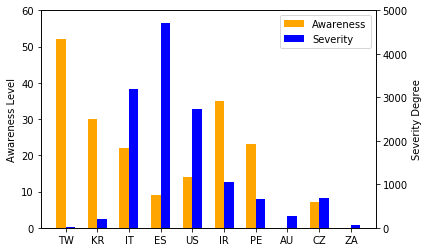

In [28]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax2 = ax.twinx()

ax.set_ylim(0, 60)
ax2.set_ylim(0, 5000)

width = 0.3

# convert data from df to arrays
country = []
for key in dict_for_hist_plot:
    country.append(key) 
n = df_for_plot.shape[0]

# set data for x, y1, y2
x = np.arange(len(country))
y1 = np.zeros(n)
y2 = np.zeros(n)
for i in range(n):
    y1[i] = df_for_plot['Awareness'][i]
    y2[i] = df_for_plot['Severity'][i]
     
aw = ax.bar(x - width / 2,y1, color = 'orange', width = width)    
se = ax2.bar(x + width / 2,y2, color = 'blue', width = width)    
ax.set_xticks(x)
ax.set_xticklabels(country)
ax.set_ylabel('Awareness Level')
ax2.set_ylabel('Severity Degree')
ax.legend([aw,se],['Awareness','Severity'])

plt.show()

## Plot the outcome of Hypothesis 2 into scatter plot

In [29]:
popul_density_with_c

,Country/Region,Country (or dependency),Density (P/Km?),Population (2020),Country Code,Severity,1/22/20,1/23/20,1/24/20,1/25/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,Name,Code
0,US,United States,36,331002651,US,2735.20,1,1,2,2,...,699706,732197,758809,784326,811865,840351,869170,905358,US,US
1,Iran,Iran,52,83992949,IR,1050.02,0,0,0,0,...,79494,80868,82211,83505,84802,85996,87026,88194,Iran,IR
2,Italy,Italy,206,60461826,IT,3192.00,0,0,0,0,...,172434,175925,178972,181228,183957,187327,189973,192994,Italy,IT
3,South Africa,South Africa,49,59308690,ZA,71.15,0,0,0,0,...,2783,3034,3158,3300,3465,3635,3953,4220,South Africa,ZA
4,"Korea, South",South Korea,527,51269185,KR,209.05,1,1,2,2,...,10635,10653,10661,10674,10683,10694,10708,10718,"Korea, South",KR
5,Spain,Spain,94,46754778,ES,4700.35,0,0,0,0,...,190839,191726,198674,200210,204178,208389,213024,219764,Spain,ES
6,Peru,Peru,26,32971854,PE,656.56,0,0,0,0,...,13489,14420,15628,16325,17837,19250,20914,21648,Peru,PE
7,Australia,Australia,3,25499884,AU,261.84,0,0,0,0,...,6522,6568,6610,6623,6645,6652,6662,6677,Australia,AU
8,Taiwan*,Taiwan,673,23816775,TW,17.97,1,1,3,3,...,395,398,420,422,425,426,427,428,Taiwan*,TW
9,Czechia,Czech Republic (Czechia),139,10708981,CZ,679.15,0,0,0,0,...,6549,6606,6746,6900,7033,7132,7187,7273,Czechia,CZ


* Reference of Scatterplot with annotation on each data point:
#### https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point

Text(0, 0.5, 'Severity Degree\n(Confirmed Cases / Million Pople)')

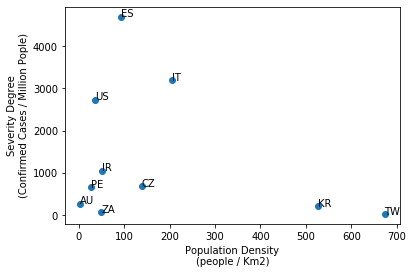

In [30]:
x = list(popul_density_with_c['Density (P/Km?)'])
y = list(popul_density_with_c['Severity'])
c = list(popul_density_with_c['Country Code'])

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(c):
    ax.annotate(txt, (x[i], y[i]))
    
plt.xlabel('Population Density\n(people / Km2)')
plt.ylabel('Severity Degree\n(Confirmed Cases / Million Pople)')

### Future Work:
### 1. Conduct linear regressions on our data to see how strong the awareness level and population density are related to the severity of pandemic

### 2. When building the country_code_dict, we need to manually search for the country names used in the dataset and modify accordingly
### --> Maybe use Regex to find similar country names? (ex: South Korea --> Korea, South)

### 3. 考慮將 "確診“, ”症狀“, ”疫情“等相關搜尋字串列入keyword list

In [31]:
pytrend = TrendReq(hl='en-US', tz=360)
pytrend.build_payload(kw_list=['武漢肺炎'], cat=0, timeframe='2020-01-01 2020-04-19', geo='TW', gprop='')
wuhan_related = pytrend.related_queries()
wuhan_related['武漢肺炎']['top']

,query,value
0,肺炎 武漢,100
1,武漢,97
2,武漢 肺炎 台灣,13
3,武漢 肺炎 疫情,11
4,武漢 疫情,11
5,武漢 肺炎 症狀,9
6,武漢 肺炎 確診,6
7,武漢 肺炎 最新,6
8,武漢 肺炎 病徵,4
9,武漢 肺炎 人數,3


In [ ]:
if __name__ == '__main__':
    
    